# Chiholonomic problem - (mixed boundary conditions) fixed initial shape with prescribed rigid body motion 

This notebook demonstrates the computation of an optimal motion path given an initial shape and a prescribed rigid body motion (RBM). The final shape is free, meaning the resulting motion is not a pure rigid body motion.

We solve a constrained optimization problem to minimize the path energy subject to the following constraints:

**Constraints**: 
 - horizontal constraints to satisfy geometric motion constraints
 - RBM constraint: the L² projection of the displacement (final shape minus initial shape) onto the space of rigid body motions equals the prescribed RBM
 

In [1]:
import os
import numpy as np
import time
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path

from constraints import *
from energies import *
from utils import * 

# # Get current working directory
working_dir = Path(os.getcwd())

### Define Optimization Parameters

- **K**: Number of time steps in the path (including start and end)
- **bending_weight**: Weight for bending energy (penalizes curvature)
- **membrane_weight**: Weight for membrane energy (penalizes stretching)
- **energy_weight**: Weight for the outer dissipation energy
- **a_weight**: Isotropic dissipation coefficient
- **b_weight**: Anisotropic dissipation coefficient (negative allows easier tangential motion)

In [2]:
# Time steps of path
K = 15
num_freeShapes = K - 1  # First and last shapes are fixed

# Specify parameters
param = {
    'bending_weight': 0.01,      # Controls resistance to bending
    'membrane_weight': 1.0,        # Controls resistance to stretching
    'energy_weight': 10.0,          # Energy weight of the outer dissipation
    'a_weight': 1.0,               # Isotropic dissipation
    'b_weight': -0.95,             # Anisotropic dissipation (negative = easier tangential motion)
    'K': K,
    'mass_factor': None,         #allows to set vertex-wise mass to model thickness of the shape, if None, it is set to 1 for all vertices
    'theta':0.3,                   # specify rotation degree for prescribed RBM
    'b': [0.2,0.1, 0.]            # specify translation for prescribed RBM
}

parameters = SimpleNamespace(**param)

print("Optimization Parameters:")
for key, value in param.items():
    print(f"  {key}: {value}")

Optimization Parameters:
  bending_weight: 0.01
  membrane_weight: 1.0
  energy_weight: 10.0
  a_weight: 1.0
  b_weight: -0.95
  K: 15
  mass_factor: None
  theta: 0.3
  b: [0.2, 0.1, 0.0]


In [3]:
def PurcellShapes(theta_1, theta_2):
    # z-coordinate set to be zero
    P = np.zeros((4,3))
    P[0] = np.array([ - 0.6, 0.1, 0.]) - np.array([ np.cos(theta_2), np.sin(theta_2), 0. ])
    P[1] = np.array([ - 0.6, 0.1, 0.])
    P[2] = np.array([ 0.4, 0.1, 0.])
    P[3] = np.array([ 0.4, 0.1, 0.]) + np.array([ np.cos(theta_1), np.sin(theta_1), 0. ])
    P = utils.scale_curve_to_unit_length(P)
    return P

In [4]:
xA = PurcellShapes(0.2, 0.4)
lines = compute_lines(xA)

N = len(xA)
print(f"Start shape has {len(xA)} vertices")
print(f"Shape dimensions: {xA.shape}")

# Create end shape that fulfils the RBM constraint with the start shape
# RBM format: [rx, ry, rz, angle, tx, ty, tz]
rbm = [0., 0., 1., parameters.theta, *parameters.b]  # Translation in x, rotation around z-axis
parameters.rbm = rbm
xB = applyRBM(xA, rbm)

parameters.center = comp_center(xB)
# Specify the plane of the 2D curves (xy-plane)
normals = np.array([0., 0., 1.])

Start shape has 4 vertices
Shape dimensions: (4, 3)


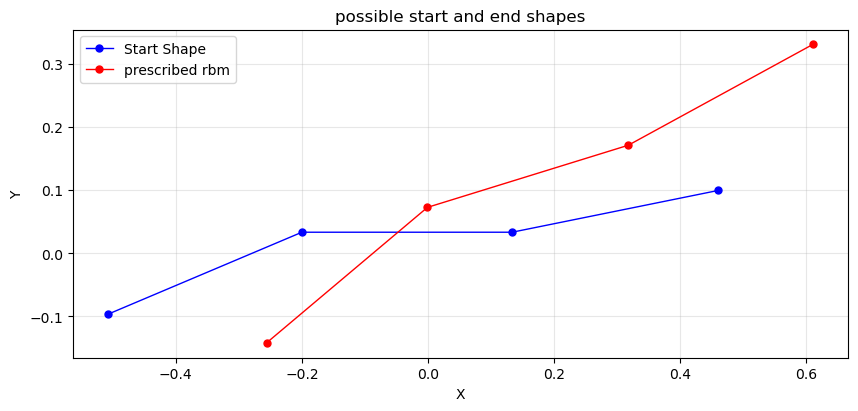

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xA[:, 0], xA[:, 1], 'o-', linewidth=1, markersize=5, label='Start Shape', color='blue')
ax.plot(xB[:, 0], xB[:, 1], 'o-', linewidth=1, markersize=5, label='prescribed rbm', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('possible start and end shapes')
ax.set_aspect('equal', 'box')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

We start with a simple "jumping" initialization where the first half of the path stays at shape A and the second half jumps to shape B.

In [6]:
# Reshape to correct format (flatten in Fortran order)
xA = xA.reshape(-1, order='F') 
xB = xB.reshape(-1, order='F')
xA = np.reshape(xA, (1, -1))
xB = np.reshape(xB, (1, -1))

print(f"xA shape: {xA.shape}")
print(f"xB shape: {xB.shape}")

# Initialize with constant path (jumping in the middle)
x0 = np.concatenate([int((K-1)/2) * [xA], int((K-1)/2) * [xB]])
x0 = x0.reshape(-1)

print(f"Initial path shape: {x0.shape}")
print(f"Total degrees of freedom: {len(x0)}")

xA shape: (1, 12)
xB shape: (1, 12)
Initial path shape: (168,)
Total degrees of freedom: 168


### Constrained Optimization for chi-holonomic problem


In [7]:
xB = None
num_freeShapes = K - 1 
args = (
    lines, normals,
    parameters.bending_weight,
    parameters.membrane_weight,
    K, xA, xB,
    parameters.energy_weight,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)

# Define horizontal constraint (6 constraints per time step)
constr_horizontal = create_horizontal_constraint(
    K, xA, xB,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)
# Define RBM constraint for prescribed RBM (6 constraints)
constr_rbm = create_chi_constraint(K, parameters.rbm)

In [8]:
print("\nStarting constrained optimization...")
print("Method: trust-constr")
print("="*60)

start_time = time.time()

optResult = scipy.optimize.minimize(
    path_energy.pathEnergy,
    x0,
    args,
    jac=path_energy.gradientPathEnergy,
    hess=path_energy.hessianPathEnergy,
    method='trust-constr',
    options={'maxiter': 3000, 'disp': True},
    constraints={constr_horizontal, constr_rbm}
)

constrained_time = time.time() - start_time

print(f"\nConstrained optimization completed in {constrained_time:.2f} seconds")
print(f"Success: {optResult.success}")
print(f"Final energy: {optResult.fun:.6f}")
print(f"Iterations: {optResult.nit}")

# Get optimized path
opt = optResult.get('x')

# Reshape and add fixed start/end shapes
pos = np.reshape(opt, (num_freeShapes, -1)) 
pos = np.concatenate((xA, pos))

# Reshape to 3D coordinates
path = pos.reshape((pos.shape[0], -1, 3), order='F')

print(f"Path shape: {path.shape}")
print(f"Number of time steps: {len(path)}")
print(f"Vertices per shape: {path.shape[1]}")


Starting constrained optimization...
Method: trust-constr
`xtol` termination condition is satisfied.
Number of iterations: 231, function evaluations: 300, CG iterations: 5182, optimality: 8.34e-08, constraint violation: 2.39e-17, execution time: 1.5e+01 s.

Constrained optimization completed in 21.93 seconds
Success: True
Final energy: 0.298315
Iterations: 231
Path shape: (15, 4, 3)
Number of time steps: 15
Vertices per shape: 4


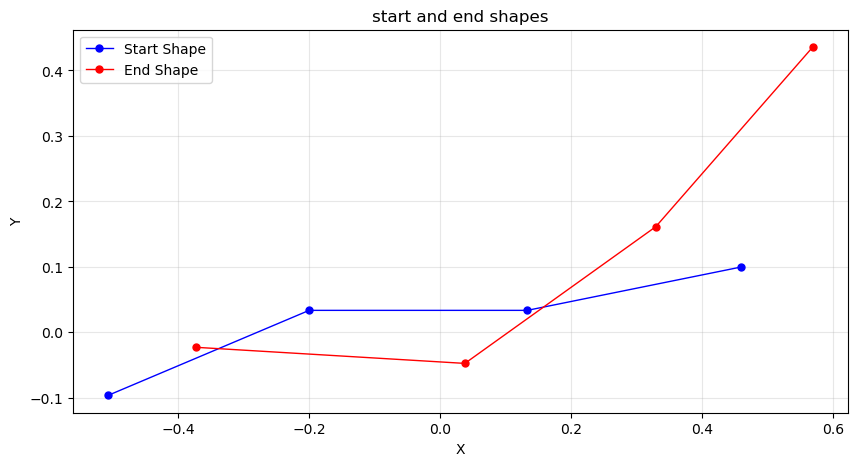

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(path[0,:, 0], path[0,:, 1], 'o-', linewidth=1, markersize=5, label='Start Shape', color='blue')
ax.plot(path[-1,:, 0], path[-1, :,1], 'o-', linewidth=1, markersize=5, label='End Shape', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('start and end shapes')
ax.set_aspect('equal', 'box')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

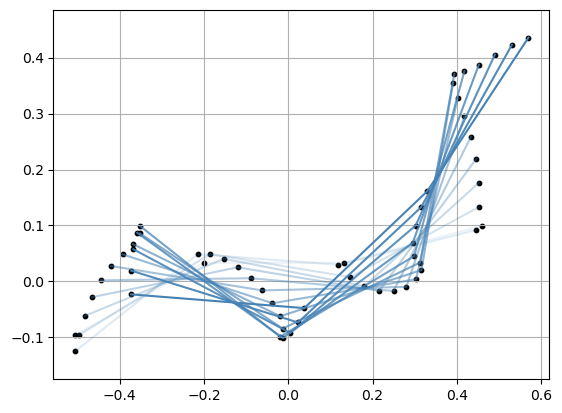

In [10]:
visualize_shape_sequence(path, save=False)

In [11]:
animate_shape_sequence(path, save=False, returnHTML=True)